In [26]:
from pathlib import Path
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import numpy as np
import cv2


def show_img(img: np.ndarray) -> None:
    plt.figure(figsize=(8,4))
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img[...,::-1])
        
def load_img(file_path: str) -> np.ndarray:
    return cv2.imread(str(file_path), 1)

def convert_img_to_grayscale(img: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_contours(img_gray: np.ndarray) -> tuple:
    ret, thresh = cv2.threshold(img_gray, 127, 255, 0)
    return cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def get_photo_contour(contours: tuple) -> np.ndarray:
    contours, hierarchy = contours
    photos = []
    for idx, val in enumerate(hierarchy[0]):
        _next, _prev, _child, _parent = val
        if _parent == 0 and _child != -1 and cv2.contourArea(contours[idx]) > 1000:
            photos.append(contours[idx])
            
    if len(photos) > 1:
        print(f"WARNING - len(photos) = {len(photos)}")
        
    return photos[0]

def get_bounding_rect(photo_contour: np.ndarray) -> tuple:
    return cv2.minAreaRect(photo_contour)

def rotate_img(img: np.ndarray) -> np.ndarray:
    img_gray = convert_img_to_grayscale(img)
    contours = get_contours(img_gray)
    photo_contour = get_photo_contour(contours)
    center, size, angle = get_bounding_rect(photo_contour)
    
    center, size = tuple(map(int, center)), tuple(map(int, size))
    
    # size = (size[1], size[0])
    
    height, width = img.shape[0] + (img.shape[0]//4), img.shape[1] + (img.shape[1]//4)

    if width < height:
        angle -= 90
    # else:
    #     # angle *= -1
    #     height += 1000
    #     width += 1000
    
    M = cv2.getRotationMatrix2D(center, angle, 1)
    img_rot = cv2.warpAffine(img, M, (width, height))
    return img_rot

def crop_img(img: np.ndarray) -> np.ndarray:
    img_gray = convert_img_to_grayscale(img)
    contours = get_contours(img_gray)
    photo_contour = get_photo_contour(contours)
    center, size, angle = get_bounding_rect(photo_contour)
    
    center, size = tuple(map(int, center)), tuple(map(int, size))
    
    img_rot = rotate_img(img)
    
    return cv2.getRectSubPix(img_rot, size, center)

In [27]:
file = Path().resolve().parent.parent / 'imgs-test' / 'middle.JPG'
file.is_file()

True

In [28]:
@dataclass
class Cropper:
    img: np.ndarray = None
    img_gray: np.ndarray = None
    img_cropped: np.ndarray = None
    img_rotated: np.ndarray = None
    contours: tuple = None
    photo_contour: np.ndarray = None
    bounding_rect: tuple = None
    center: tuple = None
    size: tuple = None
    angle: tuple = None
    
    def load_img(self, file_path) -> None:
        self.img = cv2.imread(str(file_path), 1)
        print(f"img: {type(self.img)}")
        self.img_gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        print(f"img_gray: {type(self.img_gray)}")
        
        ret, thresh = cv2.threshold(self.img_gray, 127, 255, 0)
        self.contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        print(f"contours: {len(self.contours)}")
        
        c, h = self.contours
        photos = []
        for idx, val in enumerate(h[0]):
            _next, _prev, _child, _parent = val
            if _parent == 0 and _child != -1 and cv2.contourArea(c[idx]) > 1000:
                photos.append(c[idx])
                
        if len(photos) > 1:
            print(f"WARNING - len(photos) = {len(photos)}")
        self.photo_contour = photos[0]
        print(f"photo_contour: {len(self.photo_contour)}")
        
        self.bounding_rect = cv2.minAreaRect(self.photo_contour)
        print(f"bounding_rect: {self.bounding_rect}")
        
        self.center, self.size, self.angle = self.bounding_rect
        self.center = tuple(map(int, self.center))
        self.size = tuple(map(int, self.size))
        print(f"center: {self.center}")
        print(f"size: {self.size}")
        
        h = self.img.shape[1] + (self.img.shape[1] // 4)
        w = self.img.shape[0] + (self.img.shape[0] // 4)
        print(f"h, w: {h}, {w}")
        
        
    
    def show_imgs(self) -> None:
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 12))
        
        ax[0].imshow(self.img[...,::-1])
        ax[0].set_title('Original', fontsize=20)
        
        ax[1].imshow(self.img_gray[...,::-1], cmap='gray')
        ax[1].set_title('Grayscale', fontsize=20)
        
        ax[2].imshow(self.img_rotated[...,::-1])
        ax[2].set_title('Rotated', fontsize=20)
        
        ax[3].imshow(self.img_cropped[...,::-1])
        ax[3].set_title('Cropped', fontsize=20)
        
        fig.tight_layout()
        

In [29]:
cropper = Cropper()
cropper.load_img(file)

img: <class 'numpy.ndarray'>
img_gray: <class 'numpy.ndarray'>
contours: 2
photo_contour: 9100
bounding_rect: ((885.0870971679688, 1140.389892578125), (2010.3309326171875, 1413.0399169921875), 89.260986328125)
center: (885, 1140)
size: (2010, 1413)
h, w: 3100, 4038


TypeError: 'NoneType' object is not subscriptable

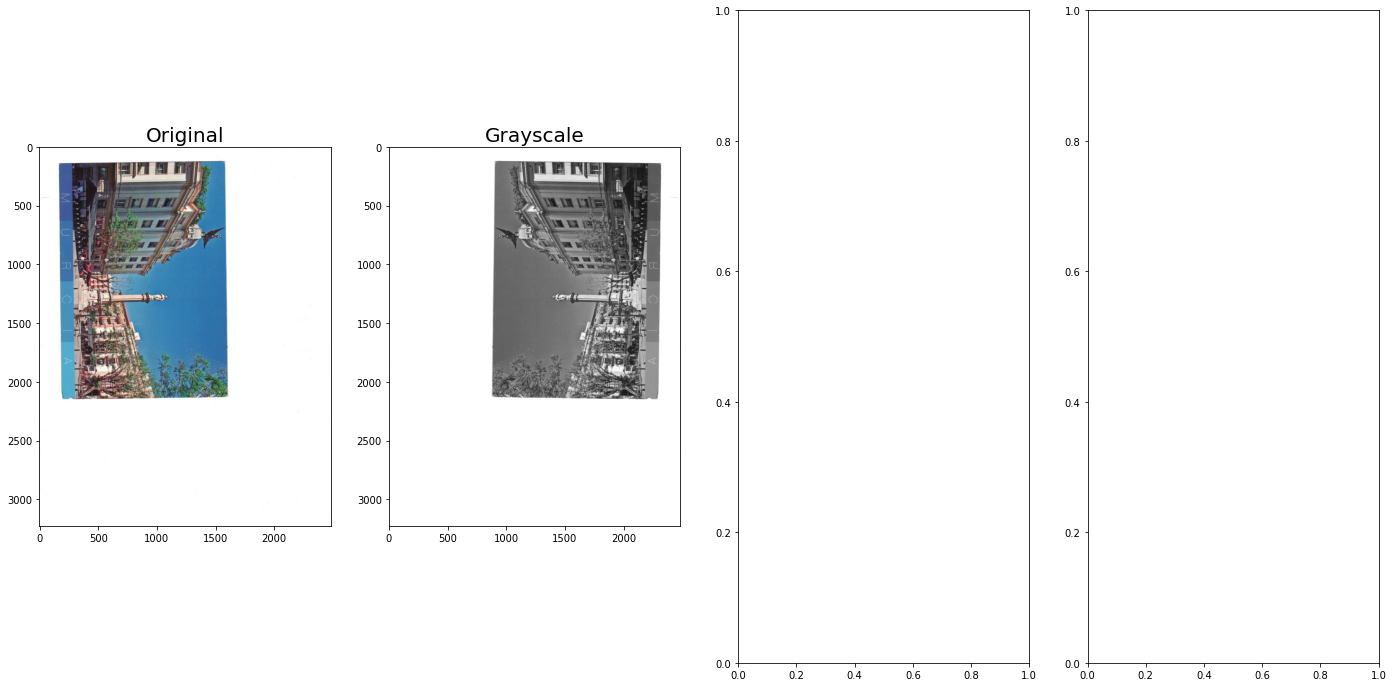

In [30]:
cropper.show_imgs()